In [2]:
import anacal
import galsim
import numpy as np
import matplotlib.pyplot as plt
import batsim
import astropy.io.fits as fits

from tqdm import tqdm, trange

from multiprocessing import Pool, cpu_count

In [3]:
# Read in galaxy images with IA
filename = 'simulations/isolated_noiseless/COSMOS_ngals=81499_noiseless.fits'

n_gals = 81499
n_scenes = 5
gals_per_scene = n_gals // n_scenes

total_indices = np.arange(0,n_gals)
split_inds = np.array_split(total_indices, n_scenes)

cosmos = galsim.COSMOSCatalog()
records = cosmos.getParametricRecord(np.arange(len(cosmos)))

i = 0
ia_cosmos_list = []
hlrs = []
use_bulge = []
fluxes = []
records_inds = []
gal_ids = []
with fits.open(filename) as hdul:
    for j in tqdm(split_inds[i]):
        # exclude the first HDU
        data = hdul[j+1].data
        ia_cosmos_list.append(data)

        gal_id = hdul[j+1].header['IDENT']
        gal_ids.append(gal_id)

        record_ind = np.where(records['IDENT'] == gal_id)[0][0]
        records_inds.append(record_ind)
        
        bulge = records['use_bulgefit'][record_ind]
        use_bulge.append(bulge)
        if bulge:
            hlrs.append(records['hlr'][record_ind][2])
            fluxes.append(records['flux'][record_ind][3])
        else:
            hlrs.append(records['hlr'][record_ind][0])
            fluxes.append(records['flux'][record_ind][0])

    ia_cosmos_scene = np.concatenate(ia_cosmos_list, axis=1)

100%|██████████| 16300/16300 [00:19<00:00, 850.67it/s]


## Example sent by Xiangchong

Effective measurement radius:  0.591272703375028


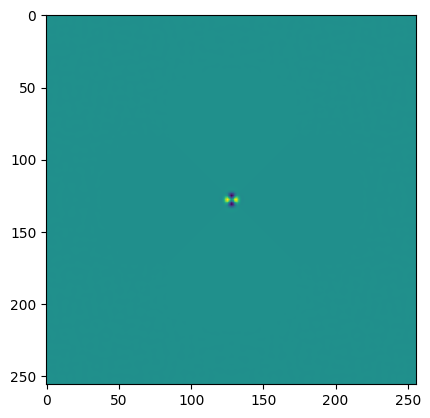

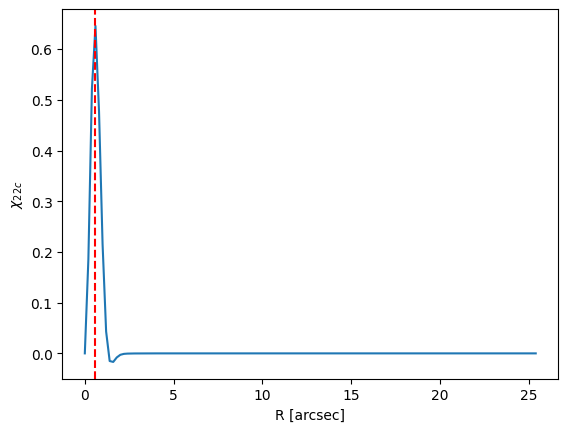

In [4]:
# We use a fine grids for the plot
pixel_scale = 0.2 # arcsec
fwhm = 0.8

# The expected LSST PSF
psf_obj = galsim.Moffat(fwhm=0.8, beta=2.5)
npix = 256
psf_data = psf_obj.shift(
    pixel_scale*0.5, pixel_scale*0.5,
).drawImage(nx=npix, ny=npix, scale=pixel_scale).array
psf_fourier = np.fft.rfft2(np.fft.fftshift(psf_data))
nord=4
det_nrot = 4
sigma_as = 0.52
mtask = anacal.fpfs.FpfsMeasure(
    mag_zero=25.3,
    psf_array=psf_data,
    pixel_scale=pixel_scale,
    sigma_arcsec=sigma_as,
    nord=nord,
    det_nrot=det_nrot,
)

# Shape kernel in Fourier space
chi22c_fourier = mtask.bfunc[mtask.di["m22c"]]
# The effecitve kernel in Configuration space
chi22c = np.fft.fftshift(np.fft.irfft2(chi22c_fourier / psf_fourier))
plt.figure()
plt.imshow(chi22c)


x = (np.arange(npix)[npix//2:] - npix//2) * pixel_scale
y = chi22c[npix//2, npix//2:]
y_norm = np.sqrt(np.sum(y ** 2.0))
y = y / y_norm
plt.figure()
plt.plot(x, y)
plt.xlabel("R [arcsec]")
plt.ylabel(r"$\chi_{22c}$")

# take moments as weights to find effective measurement radius
r_eff = np.average(x, weights=y)
print("Effective measurement radius: ", r_eff)
plt.axvline(r_eff, color="red", linestyle="--")

## Checking truncation works as intended

In [5]:
def test_truncation(hlr, npix, pixel_scale, clip_radius):

    indx = np.arange(-int(npix / 2), int((npix + 1) / 2), 1) * pixel_scale
    indy = np.arange(-int(npix / 2), int((npix + 1) / 2), 1) * pixel_scale
    inds = np.meshgrid(indy, indx, indexing="ij")
    
    # coords in shape of (2, npoints), in order of [x, y]
    coords = np.vstack([np.ravel(_) for _ in inds[::-1]])
    x, y = coords

    radial_dist = np.sqrt(abs(x) ** 2 + abs(y) ** 2)
    rwf = (radial_dist) / hlr

    # fix shear beyond rfw >= clip_radius
    rwf = np.clip(rwf, 0, clip_radius)

    shear = 0.01*rwf**0.8

    return radial_dist, shear, rwf

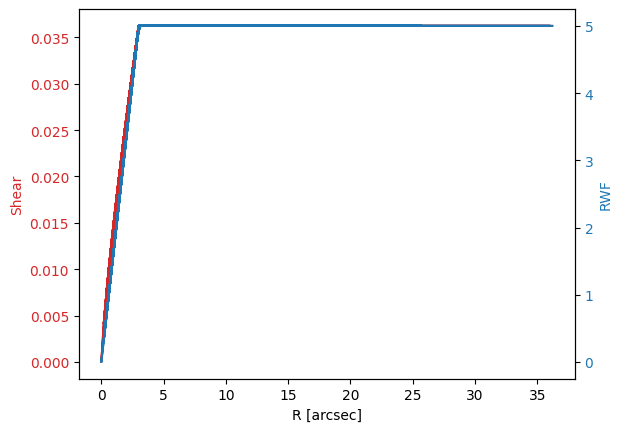

In [6]:
hlr = 0.6 # arcsec 
clip_radius = 5

radial_dist, shear, rwf = test_truncation(hlr, npix, pixel_scale, clip_radius)

# twin axes plot of shear and rwf
fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.set_xlabel('R [arcsec]')
ax1.set_ylabel('Shear', color=color)
ax1.plot(radial_dist, shear, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('RWF', color=color)
ax2.plot(radial_dist, rwf, color=color)
ax2.tick_params(axis='y', labelcolor=color)
plt.show()

## Generate galaxies

In [7]:
cosmos = galsim.COSMOSCatalog()
gal_obj_list = cosmos.makeGalaxy(n_random=100, gal_type='parametric')

lens_transform = batsim.LensTransform(gamma1=0.02, gamma2=0.0, kappa=0.0)

n_rot = 4
rotated_gal_list = []
for gal_obj in gal_obj_list:
    for i in range(n_rot):
        rot_ang = np.pi / n_rot * i
        ang = rot_ang * galsim.radians
        rotated_gal_list.append(gal_obj.rotate(ang))

print(len(rotated_gal_list))

gal_img_list = batsim.simulate_galaxy_batch(
    ngrid=npix,
    pix_scale=pixel_scale,
    gal_obj_list=rotated_gal_list,
    transform_obj=lens_transform,
    psf_obj=psf_obj,
    nproc=cpu_count()
)

400


In [8]:
# place each rotation in a quadrant of a square array
full_img_list = []

sqrt_n_rot = int(np.sqrt(n_rot))

for i in range(100):
    full_image = np.zeros((npix*2, npix*2))
    for j in range(n_rot):
        # Calculate the row and column positions
        row = j // sqrt_n_rot
        col = j % sqrt_n_rot

        # Calculate the bounds for this quadrant
        xmin = col * npix
        xmax = (col + 1) * npix
        ymin = row * npix
        ymax = (row + 1) * npix
        
        # Place in image
        full_image[ymin:ymax, xmin:xmax] = gal_img_list[i*n_rot + j]

    full_img_list.append(full_image)

print(len(full_img_list))
print(full_img_list[0].shape)

# now try inverse back into a list of single images
def split_image_into_quadrants(image, n_rot, nn):
    '''
    THIS CODE WILL SPLIT IMAGES OF 4 ROTATIONS INTO SINGLE
    IMAGES, EACH CONTAINING A SINGLE ROTATION. FOR SOME REASON
    THIS IS REQUIRED FOR THE BELOW METHOD OF MEASURING SHEAR.
    '''
    quadrants = []
    
    for j in range(n_rot):
        # Calculate the row and column positions
        row = j // sqrt_n_rot
        col = j % sqrt_n_rot

        # Calculate the bounds for this quadrant
        xmin = col * nn
        xmax = (col + 1) * nn
        ymin = row * nn
        ymax = (row + 1) * nn
        
        # Extract the quadrant
        quadrant = image[ymin:ymax, xmin:xmax]
        quadrants.append(quadrant)
    
    return quadrants

quadrant_list = []
for image in full_img_list:
    quadrants = split_image_into_quadrants(image, n_rot, npix)
    quadrant_list.extend(quadrants)

print(len(quadrant_list))
print(quadrant_list[0].shape)

100
(512, 512)
400
(256, 256)


## Attempt to measure shear for many IA'd COSMOS gals (read in at start of NB)

Text(0.5, 1.0, 'Single scene')

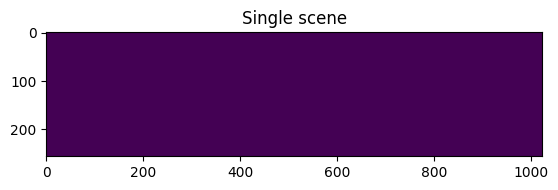

In [9]:
single_scene = np.concatenate(quadrant_list, axis=1)
gal_scene = np.concatenate(gal_img_list, axis=1)

norm = plt.Normalize(0, 0.01)

plt.figure()
plt.imshow(single_scene[:,:1024]-gal_scene[:,:1024], norm=norm)
plt.title("Single scene")

In [10]:
# Spin-2 Shape kernel in Fourier space
chi22c_fourier = mtask.bfunc[mtask.di["m22c"]]
# The effecitve kernel in Configuration space
chi22c = np.fft.fftshift(np.fft.irfft2(chi22c_fourier / psf_fourier))
# Shear response Shape kernel in Fourier space
responfun_fourier = (mtask.bfunc[mtask.di["m00"]] - mtask.bfunc[mtask.di["m40"]]) / np.sqrt(2.0)
# The effecitve kernel in Configuration space
responfun = np.fft.fftshift(np.fft.irfft2(responfun_fourier / psf_fourier))

e_sum = 0.0
res_sum = 0.0
for i in range(400):
        gal_data = gal_img_list[i] # for read in data

        e_sum += np.sum(chi22c*gal_data) 
        res_sum += np.sum(responfun*gal_data)

measured_shear = e_sum / res_sum
print("Individual Measured shear: ", measured_shear)

e_sum = 0.0
res_sum = 0.0
for i in range(400):
        gal_data = quadrant_list[i] # for read in data

        e_sum += np.sum(chi22c*gal_data) 
        res_sum += np.sum(responfun*gal_data)

measured_shear = e_sum / res_sum
print("All rotations Measured shear: ", measured_shear)

Individual Measured shear:  0.020002567643895557
All rotations Measured shear:  0.020002567643895557


## Measure from COSMOS galaxies

In [11]:
ngals = len(ia_cosmos_list)
scale = 0.2
scene_nx = ia_cosmos_scene.shape[0]
scene_ny = ia_cosmos_scene.shape[1]
nn = scene_ny // (2*ngals)

a_ia = galsim.Shear(e1=0.00136207, e2=0).g1
b_ia = 0.82404653
print(scale, scene_nx, scene_ny, nn, a_ia)

0.2 512 8345600 256 0.0006810353158702314


In [12]:
# split the scene into individual galaxies
ia_cosmos_quadrants = []
for image in ia_cosmos_list:
    quadrants = split_image_into_quadrants(image, n_rot, nn)
    ia_cosmos_quadrants.extend(quadrants)

In [13]:
e_sum = 0.0
res_sum = 0.0
for i in trange(ngals*n_rot):
        gal_data = ia_cosmos_quadrants[i] # for read in data

        e_sum += np.sum(chi22c*gal_data) 
        res_sum += np.sum(responfun*gal_data)

full_measured_shear = e_sum / res_sum
print('E sum: ', e_sum)
print('Res sum: ', res_sum)
print("Measured shear: ", full_measured_shear)

100%|██████████| 65200/65200 [00:18<00:00, 3536.03it/s]

E sum:  0.00010486711385247951
Res sum:  0.10582749259686276
Measured shear:  0.000990925054342526


Measurement radius from shear (HLR):  1.5763332381934143
Measurement radius from moments (HLR):  0.9854545056250468


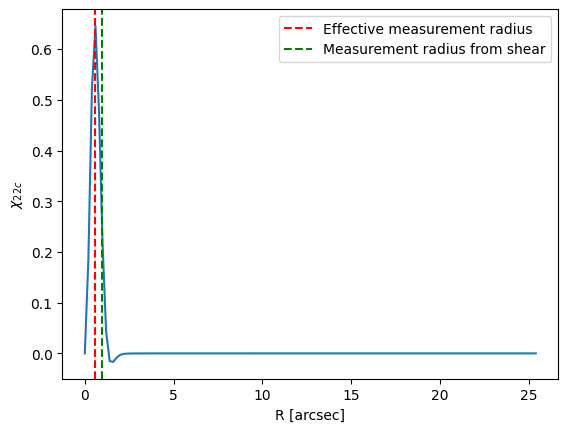

In [14]:
# Determime expected shear
#a_rwf = galsim.Shear(g1=measured_shear).e1
a_rwf = full_measured_shear
rwf = (a_rwf / a_ia) ** (1/b_ia)
print("Measurement radius from shear (HLR): ", rwf)
print("Measurement radius from moments (HLR): ", r_eff/hlr)

plt.figure()
plt.plot(x, y)
plt.xlabel("R [arcsec]")
plt.ylabel(r"$\chi_{22c}$")

# take moments as weights to find effective measurement radius
r_eff = np.average(x, weights=y)
plt.axvline(r_eff, color="red", linestyle="--", label="Effective measurement radius")
plt.axvline(rwf*hlr, color="green", linestyle="--", label="Measurement radius from shear")
plt.legend()

## Analyse shear for individual galaxies

In [15]:
individual_shears = []
individual_response = []

for i in trange(ngals):
    e_sum = 0.0
    res_sum = 0.0
    for j in range(n_rot):
        gal_data = ia_cosmos_quadrants[i*n_rot + j] # for read in data

        e_sum += np.sum(chi22c*gal_data) 
        res_sum += np.sum(responfun*gal_data)

    individual_shears.append(e_sum)
    individual_response.append(res_sum)

if len(hlrs) != len(individual_shears):
    print("Lengths do not match")
    print(len(hlrs), len(individual_shears))

individual_shears_calibrated = np.array(individual_shears) / np.array(individual_response) # per galaxy
print(individual_shears_calibrated)
sample_shear_calibrate = np.average(individual_shears) / np.average(individual_response)
print("Sample shear calibrated: ", sample_shear_calibrate)
print(full_measured_shear-sample_shear_calibrate)

100%|██████████| 16300/16300 [00:18<00:00, 905.37it/s]

[0.00188937 0.00142796 0.00170103 ... 0.00061643 0.00150839 0.00137047]
Sample shear calibrated:  0.0009909250543425287
-2.6020852139652106e-18


Text(0, 0.5, 'Shear')

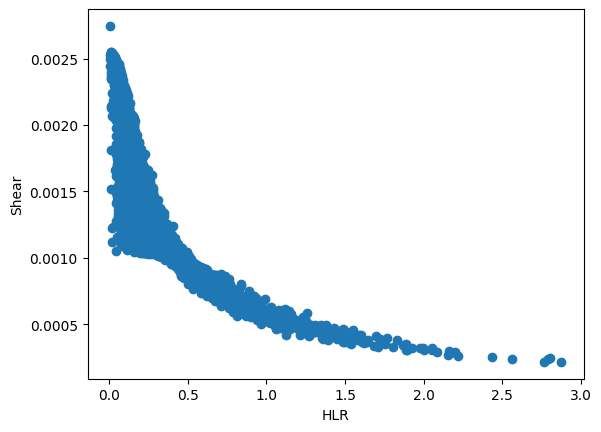

In [16]:
plt.scatter(hlrs, individual_shears_calibrated)
plt.xlabel("HLR")
plt.ylabel("Shear")

## Construct functions to carry out measurement

In [69]:
def measure_shear(sigma_as, 
                  nord, 
                  pixel_scale, 
                  psf_data, 
                  psf_fourier, 
                  gal_img_list
                  ):

    det_nrot = 4
    
    mtask = anacal.fpfs.FpfsMeasure(
        mag_zero=25.3,
        psf_array=psf_data,
        pixel_scale=pixel_scale,
        sigma_arcsec=sigma_as,
        nord=nord,
        det_nrot=det_nrot,
    )

    # Spin-2 Shape kernel in Fourier space
    chi22c_fourier = mtask.bfunc[mtask.di["m22c"]]
    # The effecitve kernel in Configuration space
    chi22c = np.fft.fftshift(np.fft.irfft2(chi22c_fourier / psf_fourier))
    # Shear response Shape kernel in Fourier space
    responfun_fourier = (mtask.bfunc[mtask.di["m00"]] - mtask.bfunc[mtask.di["m40"]]) / np.sqrt(2.0)
    # The effecitve kernel in Configuration space
    responfun = np.fft.fftshift(np.fft.irfft2(responfun_fourier / psf_fourier))

    individual_shears = []
    individual_response = []

    for i in trange(ngals):
        e_sum = 0.0
        res_sum = 0.0
        for j in range(n_rot):
            gal_data = gal_img_list[i*n_rot + j] # for read in data

            e_sum += np.sum(chi22c*gal_data) 
            res_sum += np.sum(responfun*gal_data)

        individual_shears.append(e_sum)
        individual_response.append(res_sum)

    if len(hlrs) != len(individual_shears):
        print("Lengths do not match")
        print(len(hlrs), len(individual_shears))

    sample_shear_calibrate = np.average(individual_shears) / np.average(individual_response)

    return individual_shears, individual_response, sample_shear_calibrate

gal_shears, gal_resps, sample_shear_calibrated = measure_shear(
    sigma_as=0.52, 
    nord=4, 
    pixel_scale=pixel_scale, 
    psf_data=psf_data, 
    psf_fourier=psf_fourier, 
    gal_img_list=ia_cosmos_quadrants
    )
print(sample_shear_calibrated)

  0%|          | 0/16300 [00:00<?, ?it/s]

100%|██████████| 16300/16300 [00:18<00:00, 881.21it/s]

0.0009909250543425287


In [71]:
# Measure shear with different kernels
kernels = np.linspace(0.4, 1.0, 10)

gal_shears_kernel = []
gal_resps_kernel = []
sample_shear_kernel = []
for kernel in kernels:
    gal_shears, gal_resps, sample_shear = measure_shear(
        sigma_as=kernel, 
        nord=4, 
        pixel_scale=pixel_scale, 
        psf_data=psf_data, 
        psf_fourier=psf_fourier, 
        gal_img_list=ia_cosmos_quadrants
    )
    gal_shears_kernel.append(gal_shears)
    gal_resps_kernel.append(gal_resps)
    sample_shear_kernel.append(sample_shear)

gal_shears_kernel = np.array(gal_shears_kernel)
gal_resps_kernel = np.array(gal_resps_kernel)
sample_shear_kernel = np.array(sample_shear_kernel)

100%|██████████| 16300/16300 [00:17<00:00, 951.70it/s]


Text(0.45, 0.00115, 'delta_Yia: 0.0003\n a: 0.7550')

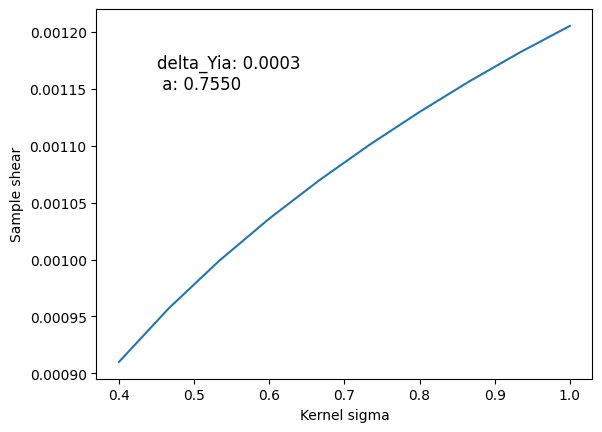

In [72]:
# Plot results for different kernels
plt.figure()
plt.plot(kernels, sample_shear_kernel)
plt.xlabel("Kernel sigma")
plt.ylabel("Sample shear")

# determine ratio of min and max shear
delta_Yia = sample_shear_kernel[-1] - sample_shear_kernel[0]
a = sample_shear_kernel[0]/sample_shear_kernel[-1]

plt.text(x=0.45, y= 0.00115, s=f"delta_Yia: {delta_Yia:.4f}\n a: {a:.4f}", fontsize=12)

(10, 16300)


Text(0, 0.5, 'Effective Radial Weighting (HLR)')

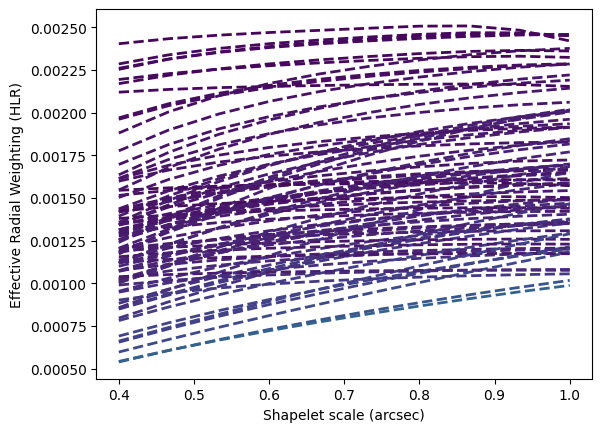

In [76]:
import matplotlib

# Plot for individual galaxies
plt.figure()
minima = min(hlrs)
maxima = max(hlrs)

norm = matplotlib.colors.Normalize(vmin=minima, vmax=maxima, clip=True)
mapper = matplotlib.cm.ScalarMappable(norm=norm, cmap=matplotlib.cm.viridis)

#reshape gal_shears_kernel to [ngals, nkernels]
gal_shears_kernel = np.array(gal_shears_kernel)
print(gal_shears_kernel.shape)

hlr_cut = 0.
for i in range(ngals):
    if hlrs[i] > hlr_cut:
        if i % 200 == 0:
            color = mapper.to_rgba(hlrs[i])
            calibrated = gal_shears_kernel[:,i] / gal_resps_kernel[:,i]
            plt.plot(kernels, calibrated, c=color, lw=2, ls='--', label=f'Galaxy {gal_ids[i]}')

plt.xlabel('Shapelet scale (arcsec)')
plt.ylabel('Effective Radial Weighting (HLR)')
#plt.legend()

(10, 10)


Text(0, 0.5, 'a')

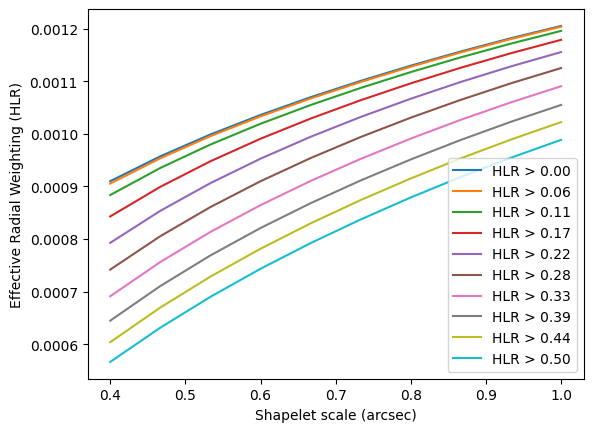

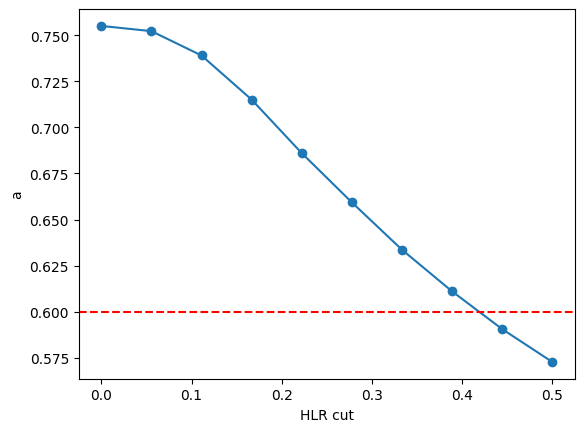

In [89]:
# Calulcate sample shear for different HLR cuts
hlr_cuts = np.linspace(0., 0.5, 10)

sample_shear_hlr = np.empty((len(hlr_cuts), len(kernels)))
for i, cut in enumerate(hlr_cuts):
    for j in range(len(kernels)):
        gal_shear_hlr = gal_shears_kernel[j,hlrs > cut]
        gal_resp_hlr = gal_resps_kernel[j,hlrs > cut]
        sample_shear_hlr[i,j] = np.average(gal_shear_hlr) / np.average(gal_resp_hlr)
sample_shear_hlr = np.array(sample_shear_hlr)
print(sample_shear_hlr.shape)

plt.figure()
for i in range(len(hlr_cuts)):

    
    plt.plot(kernels, sample_shear_hlr[i], label=f'HLR > {hlr_cuts[i]:.2f}')

plt.xlabel('Shapelet scale (arcsec)')
plt.ylabel('Effective Radial Weighting (HLR)')
plt.legend()

#calculate ratio of min and max shear
a = np.array([sample_shear_hlr[i,0]/sample_shear_hlr[i,-1] for i in range(len(hlr_cuts))])

plt.figure()
plt.plot(hlr_cuts, a, marker='o')
plt.axhline(y=0.6, color='r', linestyle='--')
plt.xlabel('HLR cut')
plt.ylabel('a')